<a href="https://colab.research.google.com/github/MatiValenzuela/ELO308-DataAugmentationForParkinsonDetection/blob/main/DataAugmentation_SpeedChange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas

In [ ]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image

import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import seaborn as sn
import sklearn
from sklearn.manifold import TSNE
from imblearn.metrics import sensitivity_specificity_support

import soundfile as sf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
audio_data_path = '/content/drive/MyDrive/Memoria/Pataka'

KeyboardInterrupt: 

## Carga de datos Gita
En primer lugar se genera un dataframe que incluye el path a los distintos archivos de audio, un ID y un tag siendo 'PD' = 1 y 'HC' = 0

In [ ]:
DATA_PATH_Gita = '/content/drive/MyDrive/Memoria/Pataka'

SAMPLE_RATE = 44100
#AVPEPUDEAC0001_pataka.wav   -> Formato de los archivos
data_Gita = pd.DataFrame(columns=['Speaker_ID', 'Label', 'Path'])
Speaker_PD=0
Speaker_HC=50 #Sabemos que son 50 muestras por cada uno.

for dirname, _, filenames in os.walk(DATA_PATH_Gita):

    for filename in filenames:
        file_path = os.path.join(dirname, filename)

        if dirname.find('PD')!=-1:
            Speaker_PD+=1
            Speaker_ID=Speaker_PD
            Label=1
        else:
            Speaker_HC+=1
            Speaker_ID=Speaker_HC
            Label=0


        data_Gita=pd.concat([data_Gita, pd.DataFrame({"Speaker_ID": [Speaker_ID],
                            "Label": [Label],
                            "Path": [file_path]
                             })],ignore_index=True)
print("number of files is {}".format(len(data_Gita)))
data_Gita.head()

number of files is 100


,Speaker_ID,Label,Path
0,1,1,/content/drive/MyDrive/Memoria/Pataka/PD/AVPEP...
1,2,1,/content/drive/MyDrive/Memoria/Pataka/PD/AVPEP...
2,3,1,/content/drive/MyDrive/Memoria/Pataka/PD/AVPEP...
3,4,1,/content/drive/MyDrive/Memoria/Pataka/PD/AVPEP...
4,5,1,/content/drive/MyDrive/Memoria/Pataka/PD/AVPEP...


In [ ]:
print('Data Gita')
print('Parkinson')
PD_Gita=data_Gita[data_Gita['Label']==1].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(PD_Gita)
print('size=', PD_Gita.shape)
print('Control')
HC_Gita=data_Gita[data_Gita['Label']==0].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(HC_Gita)
print('size=', HC_Gita.shape)

#Partition Gita
Train_Subject_Gita=np.concatenate([PD_Gita, HC_Gita])
print("Data Gita")
print("To train:",np.unique(Train_Subject_Gita).shape)
data_train_Gita=data_Gita

Data Gita
Parkinson
[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
size= (50,)
Control
[51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98
 99 100]
size= (50,)
Data Gita
To train: (100,)


## Carga de datos Neurovoz

In [ ]:
DATA_PATH_NeuroV = '/content/drive/MyDrive/Memoria/Neurovoz/PATAKA'

SAMPLE_RATE_NeuroV = 44100
data_NeuroV = pd.DataFrame(columns=['Speaker_ID', 'Label', 'Path'])
for dirname, _, filenames in os.walk(DATA_PATH_NeuroV):
    for filename in filenames:
            file_path = os.path.join(dirname, filename)
            if filename.find('wav')!=-1:
                identifiers=filename.split('.')[0].split('_')
                Speaker_ID=int(identifiers[2])+100
                if identifiers[0]=='PD':
                    Label=1
                else:
                    Label=0
            data_NeuroV=pd.concat([data_NeuroV, pd.DataFrame({"Speaker_ID": [Speaker_ID],
                            "Label": [Label],
                            "Path": [file_path]
                             })],ignore_index=True)
print("number of files is {}".format(len(data_NeuroV)))
data_NeuroV.head()

number of files is 86


,Speaker_ID,Label,Path
0,134,0,/content/drive/MyDrive/Memoria/Neurovoz/PATAKA...
1,160,0,/content/drive/MyDrive/Memoria/Neurovoz/PATAKA...
2,149,0,/content/drive/MyDrive/Memoria/Neurovoz/PATAKA...
3,153,0,/content/drive/MyDrive/Memoria/Neurovoz/PATAKA...
4,136,0,/content/drive/MyDrive/Memoria/Neurovoz/PATAKA...


In [ ]:
print('Data NeuroVoz')
print('Parkinson')
PD_NeuroV=data_NeuroV[data_NeuroV['Label']==1].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(PD_NeuroV)
print('size=', PD_NeuroV.shape)
print('Control')
HC_NeuroV=data_NeuroV[data_NeuroV['Label']==0].sort_values(by=['Speaker_ID'])['Speaker_ID'].unique()
print(HC_NeuroV)
print('size=', HC_NeuroV.shape)

#Partition NeuroVoz
Train_Subject_NeuroV=np.concatenate([PD_NeuroV, HC_NeuroV])
print("Data NeuroVoz")
print("To test:",np.unique(Train_Subject_NeuroV).shape)
data_test_NeuroV=data_NeuroV

Data NeuroVoz
Parkinson
[106 107 108 109 110 111 112 113 115 116 117 118 119 120 124 125 127 128
 129 130 131 132 133 135 137 138 139 140 141 142 143 144 146 147 166 168
 169 170 177 209 211 213 215 217]
size= (44,)
Control
[134 136 148 149 151 152 153 154 155 156 160 161 162 163 164 172 174 175
 176 181 182 185 186 205 212 216 218 220 222 228 230 231 232 234 236 237
 238 240 241 242 243 245]
size= (42,)
Data NeuroVoz
To test: (86,)


# Train with: Gita

## Procesamiento de los datos
Primero segmentamos nuestras señales.
En esta sección se realiza el data augmentation.
https://librosa.org/doc/main/_modules/librosa/effects.html#time_stretch


In [ ]:
#selecting 400ms overlap in 50ms of audio signal example
def process_select_signals(data, SAMPLE_RATE, want_to_augment = True):
    time_leng=0.4 #Esto son 400 ms.
    sample_leng=int(time_leng*SAMPLE_RATE) #Sample_rate = 44100. sample_leng = 0.4*44100 = 17640
    overloap=2
    signals, y_label, subject_group, tono =[],[],[],[]
    data_size = len(data)
    total_segments=0
    processed_audios = 0

    if want_to_augment:
      augmentedSignals, augmentedY_label, augmentedSubject_group =[],[],[]
      augmented_data_counter = 0
      augment_offset = 1000



    #Processs data to train
    for data_ind, file_path in enumerate(data.Path): #Obtengo los paths a los datos de audio
        audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE) #Cargo la señal de audio.

        augmented_flag = False

        if want_to_augment:
          prob_aug = random.random()
          if prob_aug <= 1: #Se va a aplicar siempre en este caso
            #Aplico data augmentation
            speed_rate = random.uniform(0.5,1.6)
            augmented_audio = librosa.effects.time_stretch(audio,rate=speed_rate)

            data_size += 1 #Tengo un audio más que procesar, el aumentado
            augmented_flag = True
            augmented_data_counter += 1

          #else: No aplico data augmentantion

        for a in range(2): #Pasamos 2 veces, una con el original, otra con el aumentado
          if want_to_augment and augmented_flag and a == 1:
              audio = augmented_audio
              #print("Now with the augmented data")
          elif (want_to_augment == False or augmented_flag == False) and a == 1:
              break;

          audio_len=len(audio)
          audio=audio/np.max(abs(audio)) #normalizamos
          indx=[i for i,x in enumerate(np.sqrt(abs(audio))) if x>.30]

          segments=0 #Segmentos de señal
          if (indx[0]+sample_leng)<audio_len:
              for i in range(int((-indx[0]+indx[len(indx)-1])/(sample_leng/overloap))):
                  ind_start = i * int(sample_leng/overloap)+indx[0]
                  ind_end = ind_start + sample_leng
                  if ind_end <= indx[len(indx)-1]:
                      signal=np.zeros(sample_leng)
                      signal = audio[ind_start:int(ind_end)]

                      if want_to_augment and augmented_flag and a == 1:
                        #print("Adding segment to the augmented list")
                        augmentedSignals.append(signal) #Guardo segmentos de las señales aumentadas
                        augmentedY_label.append(data.iloc[data_ind]['Label']) #Guardo su clasificación
                        augmentedSubject_group.append(data.iloc[data_ind]['Speaker_ID'] + augment_offset) #Guardo su ID del sujeto

                      elif a == 0:
                        #print("Adding segment to the real list")
                        signals.append(signal) #Guardo segmentos de las señales originales
                        y_label.append(data.iloc[data_ind]['Label']) #Guardo su clasificación
                        subject_group.append(data.iloc[data_ind]['Speaker_ID']) #Guardo su ID del sujeto

                      segments=segments+1
              processed_audios += 1
              print(" Processed {}/{} files".format(processed_audios,data_size),end='')
              print(" Time audio: {} Segments {} ".format((audio_len-1)/sample_rate,segments))
          else:
              print(" Processed {}/{} files".format(processed_audios,data_size),end='')
              print(" Time audio: {} Segments {} ".format((audio_len-1)/sample_rate,0))
          total_segments += segments

    print(" Total segments: ", total_segments)

    signals = np.stack(signals,axis=0)
    y_label = np.stack(y_label,axis=0)
    subject_group = np.stack(subject_group,axis=0)

    if want_to_augment:
      augmentedSignals = np.stack(augmentedSignals,axis=0)
      augmentedY_label = np.stack(augmentedY_label,axis=0)
      augmentedSubject_group = np.stack(augmentedSubject_group,axis=0)
      print(" Total augmentations: ", augmented_data_counter)
      return signals, y_label, subject_group, augmentedSignals, augmentedY_label, augmentedSubject_group

    else:
      return signals, y_label, subject_group

In [ ]:
# Data train GITA + Data Augmentation
signals_train_Gita, y_label_train_Gita, subject_group_train_Gita, aug_signals, aug_labels, aug_groups = process_select_signals(data_train_Gita, SAMPLE_RATE)

print("-"*40)
# Data test NeuroVoz (sin data augmentation)
signals_test_NeuroV, y_label_test_NeuroV, subject_group_test_NeuroV = process_select_signals(data_test_NeuroV, SAMPLE_RATE, want_to_augment = False)

 Processed 1/101 files Time audio: 3.2960090702947844 Segments 14 
 Processed 2/101 files Time audio: 3.2960090702947844 Segments 14 
 Processed 3/102 files Time audio: 7.261950113378685 Segments 34 
 Processed 4/102 files Time audio: 7.261950113378685 Segments 34 
 Processed 5/103 files Time audio: 6.469138321995465 Segments 30 
 Processed 6/103 files Time audio: 6.469138321995465 Segments 30 
 Processed 7/104 files Time audio: 2.5204761904761903 Segments 9 
 Processed 8/104 files Time audio: 2.5204761904761903 Segments 9 
 Processed 9/105 files Time audio: 7.466031746031746 Segments 35 
 Processed 10/105 files Time audio: 7.466031746031746 Segments 35 
 Processed 11/106 files Time audio: 6.533945578231292 Segments 30 
 Processed 12/106 files Time audio: 6.533945578231292 Segments 30 
 Processed 13/107 files Time audio: 4.915079365079365 Segments 22 
 Processed 14/107 files Time audio: 4.915079365079365 Segments 22 
 Processed 15/108 files Time audio: 4.467210884353742 Segments 20 
 P

### Verificación de tamaños

GITA

In [ ]:
print('size data train', signals_train_Gita.shape)  # Debería dar size data train (1962, 17640).
print('size labels train', y_label_train_Gita.shape)
print('size group subject train', subject_group_train_Gita.shape)

size data train (1962, 17640)
size labels train (1962,)
size group subject train (1962,)


In [ ]:
print('size augmented signals', aug_signals.shape)
print('size labels augmented', aug_labels.shape)
print('size group subject augmented', aug_groups.shape)

size augmented signals (2207, 17640)
size labels augmented (2207,)
size group subject augmented (2207,)


NeuroVoz

In [ ]:
print('size data test', signals_test_NeuroV.shape)  # Debería dar size data test (4985, 17640).
print('size labels test', y_label_test_NeuroV.shape)
print('size group subject test', subject_group_test_NeuroV.shape)

size data test (4985, 17640)
size labels test (4985,)
size group subject test (4985,)


## Espectrogramas

In [ ]:
def compute_norm_spect(signals, sample_rate):
    n_fft = 2048 #Numero de puntos
    win_length = int(0.015*sample_rate)  # Tamaño de la ventana
    hop_length = int(0.010*sample_rate)  # Tamaño del Hop
    n_mels = 65                          # Número de ventanas de Mel

    mel_spectrogram = T.MelSpectrogram(  #T from torchaudio.transforms. Configuración del espectrograma de Mel
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        #onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )


    mel_spectrograms = []
    scaler = StandardScaler()
    print("Calculating mel spectrograms")
    for i in range(signals.shape[0]):
        mel_spect = librosa.power_to_db(mel_spectrogram(torch.from_numpy(signals[i,:]))) #Calculamos el MelSpectrogram y Transformación a dB
        mel_spect_norm=scaler.fit_transform(mel_spect) #Normalizamos a media 0, stdDev 1
        mel_spectrograms.append(mel_spect_norm) #Guardamos los espectrogramas.
        print("\r Processed {}/{} files".format(i,signals.shape[0]),end='')
    mel_spectrograms = np.stack(mel_spectrograms,axis=0)
    print(' ')
    return mel_spectrograms

In [ ]:
#Data train
mel_spectrograms_train_Gita=compute_norm_spect(signals_train_Gita, SAMPLE_RATE)
print('Data size:',mel_spectrograms_train_Gita.shape)
print("-"*40)

aug_mel_spectrograms = compute_norm_spect(aug_signals, SAMPLE_RATE)
print('Data size:',aug_mel_spectrograms.shape)
print("-"*40)

#Data test
mel_spectrograms_test_NeuroV=compute_norm_spect(signals_test_NeuroV, SAMPLE_RATE)
print('Data size:',mel_spectrograms_test_NeuroV.shape)

Calculating mel spectrograms
 Processed 1961/1962 files 
Data size: (1962, 65, 41)
----------------------------------------
Calculating mel spectrograms
 Processed 1961/1962 files 
Data size: (1962, 65, 41)
----------------------------------------
Calculating mel spectrograms
 Processed 4984/4985 files 
Data size: (4985, 65, 41)


## Verificación visual y auditiva

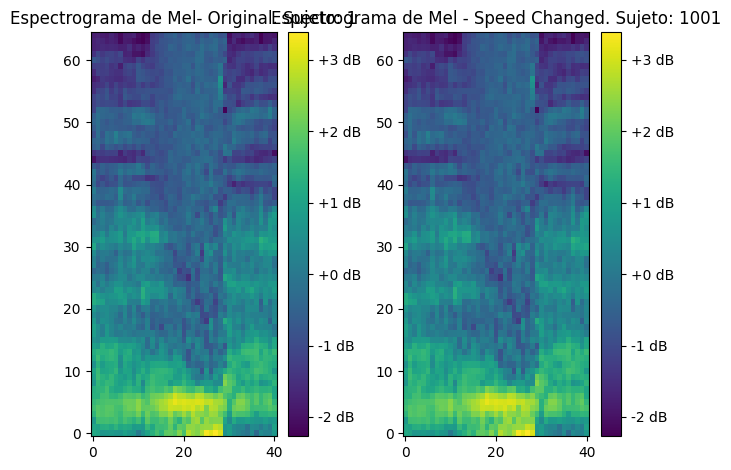

In [ ]:
#Sólo para ver, no es necesario ejecutarla.
offset = 0
plt.subplot(1, 2, 1)
plt.imshow(mel_spectrograms_train_Gita[offset], cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Mel- Original. Sujeto: {}'.format(subject_group_train_Gita[offset]))

plt.subplot(1, 2, 2)
plt.imshow(aug_mel_spectrograms[offset], cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Mel - Speed Changed. Sujeto: {}'.format(aug_groups[offset]))

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Memoria/Imagenes/speedChange_segmented.png')
plt.show()

In [ ]:
#Pruebas para escuchar - Original Segmentado
sujeto = 0
Audio(signals_train_Gita[sujeto],rate=SAMPLE_RATE)

In [ ]:
#Pruebas para escuchar - Aumentado Segmentado
Audio(aug_signals[sujeto],rate=SAMPLE_RATE)

In [ ]:
#Pruebas para escuchar - Original Completo
original, sample_rate = librosa.load(data_train_Gita['Path'][sujeto], sr=SAMPLE_RATE)
Audio(original, rate=SAMPLE_RATE)

In [ ]:
#Pruebas para escuchar - Aumentado Completo
y_stretch = original.copy()
rate = 0.5
y_stretch = librosa.effects.time_stretch(y_stretch,rate=rate)
sf.write('/content/drive/MyDrive/Memoria/audiosAumentados/speedChange_completa_05.wav', y_stretch, SAMPLE_RATE)
Audio(y_stretch, rate=SAMPLE_RATE)

## Diseño y entrenamiento de la red convolucional

In [ ]:
class CNN(nn.Module):

        def __init__(self, kernel_size_1=8, kernel_size_2=9, depth_CL=64, neurons_MLP=64, drop_out=0.2):
            super().__init__()

            # 1. conv block
            self.conv2Dblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                       out_channels=depth_CL,
                       kernel_size=kernel_size_1,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(depth_CL),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=drop_out),
            )

            # 2. conv block
            self.conv2Dblock2 = nn.Sequential(
            nn.Conv2d(in_channels=depth_CL,
                       out_channels=depth_CL,
                       kernel_size=kernel_size_2,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(depth_CL),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=drop_out),

            )

            self.MLP = nn.Sequential(
                nn.Linear(depth_CL*math.ceil((math.ceil((65-kernel_size_1)/2+1)-kernel_size_2)/2+1)
                          *math.ceil((math.ceil((41-kernel_size_1)/2+1)-kernel_size_2)/2+1),neurons_MLP),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            )

            self.out_softmax = nn.Sequential(
                nn.Linear(neurons_MLP,2),
                nn.Softmax(dim=1)
            )


        def forward(self,x):
            x = self.conv2Dblock1(x)
            conv_embedding = self.conv2Dblock2(x)
            conv_embedding = torch.flatten(conv_embedding, start_dim=1)
            MPL_output = self.MLP(conv_embedding)
            output_softmax = self.out_softmax(MPL_output)
            return output_softmax, MPL_output

In [ ]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def soft_output_by_subject(output_test, Y_test, subject_group_test, ):

    Y_test_bySubject= []
    output_test_bySubjects=torch.empty((1,2),device=output_test.device.type)
    subject_in_group=np.unique(subject_group_test)
    output_test_subject=torch.zeros(subject_in_group.shape)
    Y_estimated_test_subject=torch.ones(subject_in_group.shape)
    for i, speaker in enumerate(subject_in_group):
        index_speaker = np.where(subject_group_test==speaker)
        output_test_subject[i]=torch.mean(torch.log(output_test[index_speaker][:,1]) -torch.log(output_test[index_speaker][:,0]),0)
        Y_test_bySubject.append(Y_test[index_speaker][0])


    Y_test_tensor_bySubject = torch.tensor(Y_test_bySubject,dtype=torch.long,device=device)
    Y_estimated_test_subject[output_test_subject<0]=0
    return output_test_subject , Y_test_tensor_bySubject,Y_estimated_test_subject

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=10)

Data_Gita_strat=sgkf.split(mel_spectrograms_train_Gita, y=y_label_train_Gita, groups=subject_group_train_Gita)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("cuda")
    #torch.cuda.set_device(1)

BATCH_SIZE = 64


#Data to test NeuroV
X_test_NeuroV =np.expand_dims(np.stack(mel_spectrograms_test_NeuroV, axis=0),1)
Y_test_NeuroV= y_label_test_NeuroV
X_test_tensor_NeuroV = torch.tensor(X_test_NeuroV,device=device).float()
Y_test_tensor_NeuroV = torch.tensor(Y_test_NeuroV,dtype=torch.long,device=device)


#Métricas del modelo
results_val_metric_subject_Gita  = []
Subject_Sen_spe_Gita, Subject_f1_score_Gita, Subject_MCC_Gita, Subject_AUC_Gita=[],[],[],[]
Subject_fpr_Gita, Subject_tpr_Gita=[],[]
results_loss_Epochs, results_metric_Epochs= [], []
results_val_metric_Gita_Epochs, results_val_loss_Gita_Epochs=[],[]

#Métricas de validación con el mismo dataset
val_windows_metrics_Gita, val_subject_metrics_Gita=[],[]

#Para test con Neurovoz
test_windows_metrics_NeuroV, test_subject_metrics_NeuroV=[],[]

#Para T-SNE:
flattern_train_CNN_Original, Y_train_Original_fold =[],[]
flattern_train_CNN_Augmented, Y_train_Augmented_fold =[],[]

#Para Covarianza y divergencia
Y_Original_fold=[]
Y_Augmented_fold =[]
#flattern_output_CNN_Original, Y_val_Original_fold=[],[]
#flattern_output_CNN_Augmented, Y_val_Augmented_fold =[],[]

for k in range(10):
    results_loss, results_metric, results_val_metric_Gita, results_val_loss_Gita,  = [], [], [], []


    print('')
    print(f"\k-fold {k + 1} \n***********************")

    train_index_Gita, val_index_Gita =next(iter(Data_Gita_strat))

    print(np.unique(subject_group_train_Gita[val_index_Gita])) #Imprimo los índices que serán usados en validation


    #Variables para T-SNE
    X_Original = np.expand_dims(np.stack(mel_spectrograms_train_Gita[train_index_Gita,:,:], axis=0),1)
    X_tensor_Original = torch.tensor(X_Original,device=device).float()
    Y_tensor_Original = torch.tensor(y_label_train_Gita[train_index_Gita], dtype=torch.long,device=device)

    X_Augmented = np.expand_dims(np.stack(aug_mel_spectrograms, axis=0),1)
    X_tensor_Augmented = torch.tensor(X_Augmented,device=device).float()
    Y_tensor_Augmented = torch.tensor(aug_labels, dtype=torch.long,device=device)

    #Data to train. Augmented variables: aug_signals, aug_labels, aug_groups, aug_mel_spectrograms

    X_train = np.expand_dims(np.stack(np.concatenate([mel_spectrograms_train_Gita[train_index_Gita,:,:], aug_mel_spectrograms], axis=0), axis=0),1) #Acá poner + augmentedSpec
    Y_train = np.concatenate([y_label_train_Gita[train_index_Gita], aug_labels],axis=0) #Aca igua ponerle las de augmented

    X_tensor = torch.tensor(X_train,device=device).float()
    Y_tensor = torch.tensor(Y_train, dtype=torch.long,device=device)

    subject_group_train=np.concatenate([subject_group_train_Gita[train_index_Gita], aug_groups],axis=0)#Acá igual concatenar las de augmented


    #Data to val Gita
    X_val_Gita =np.expand_dims(np.stack(mel_spectrograms_train_Gita[val_index_Gita,:,:], axis=0),1)
    Y_val_Gita= y_label_train_Gita[val_index_Gita]
    subject_group_val_Gita=subject_group_train_Gita[val_index_Gita]
    X_val_tensor_Gita = torch.tensor(X_val_Gita,device=device).float()
    Y_val_tensor_Gita = torch.tensor(Y_val_Gita,dtype=torch.long,device=device)


    DATASET_SIZE=X_train.shape[0]
    iters = int(DATASET_SIZE / BATCH_SIZE)

    model = CNN().to(device)
    model.apply(reset_weights)


    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    lambda1 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


    dataset=TensorDataset(X_tensor,Y_tensor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(100): #100 épocas
        epoch_acc = 0
        epoch_loss = 0
        for id_batch, (x_batch, y_batch) in enumerate(dataloader):
            actual_batch_size=x_batch.shape[0]

            # zero the parameter gradients
            model.train()
            optimizer.zero_grad()

            # forward
            outputs = model(x_batch)[0]

            # calculate accuracy
            prediction = torch.max(outputs, 1)[1]
            metric = sklearn.metrics.accuracy_score(y_batch.data.cpu(), prediction.data.cpu())*100


            # calculate loss + backward + optimize
            loss = loss_func(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_acc += metric*actual_batch_size/DATASET_SIZE
            epoch_loss += loss.item()*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch +1}: iteration {id_batch +1}/{iters} Acc_class: {epoch_acc:.2f}",end='')


        scheduler.step()

        with torch.no_grad():
            model.eval()
            output_val_Gita = model(X_val_tensor_Gita)[0]
            prediction_val_Gita = torch.max(output_val_Gita, 1)[1]
            val_metric_Gita = sklearn.metrics.accuracy_score(Y_val_tensor_Gita.data.cpu(), prediction_val_Gita.data.cpu())*100
            val_loss_Gita = loss_func(output_val_Gita, Y_val_tensor_Gita.data)

            output_val_bySubjects_Gita, Y_val_tensor_bySubject_Gita, prediction_val_bySubject_Gita =soft_output_by_subject(output_val_Gita, Y_val_Gita, subject_group_val_Gita)
            val_metric_subject_Gita = sklearn.metrics.accuracy_score(Y_val_tensor_bySubject_Gita.data.cpu(), prediction_val_bySubject_Gita.data.cpu())*100

        # append history
        results_loss.append(epoch_loss)
        results_metric.append(epoch_acc)
        results_val_metric_Gita.append(val_metric_Gita)
        results_val_metric_subject_Gita.append(val_metric_subject_Gita)
        results_val_loss_Gita.append(val_loss_Gita.item())


    print('')
    print(f"\r validation Gita: {val_metric_Gita:.2f} % by Subject: {val_metric_subject_Gita:.2f}%  ")

    #compute metrics
    Sen_spe_subject_Gita=sensitivity_specificity_support(Y_val_tensor_bySubject_Gita.data.cpu(), prediction_val_bySubject_Gita.data.cpu(), average='binary')*100
    val_f1_score_Gita = sklearn.metrics.f1_score(Y_val_tensor_bySubject_Gita.data.cpu(), prediction_val_bySubject_Gita.data.cpu())*100
    val_MCC_Gita = sklearn.metrics.matthews_corrcoef(Y_val_tensor_bySubject_Gita.data.cpu(), prediction_val_bySubject_Gita.data.cpu())
    val_fpr_Gita, val_tpr_Gita, _ = sklearn.metrics.roc_curve(Y_val_tensor_bySubject_Gita.data.cpu(), output_val_bySubjects_Gita.data.cpu())
    val_AUC_Gita = sklearn.metrics.auc(val_fpr_Gita, val_tpr_Gita)

    #Métricas para T-SNE
    with torch.no_grad():
        model.eval()
        output_train_Original, train_CNN_Original = model(X_tensor_Original)
        output_train_Augmented, train_CNN_Augmented = model(X_tensor_Augmented)

    with torch.no_grad():
        model.eval()
        output_test_NeuroV, output_CNN_NeuroV = model(X_test_tensor_NeuroV)
        prediction_test_NeuroV = torch.max(output_test_NeuroV, 1)[1]

    test_metric_NeuroV = sklearn.metrics.accuracy_score(Y_test_tensor_NeuroV.data.cpu(), prediction_test_NeuroV.data.cpu())*100

    output_test_bySubjects_NeuroV, Y_test_tensor_bySubject_NeuroV, prediction_test_bySubject_NeuroV =soft_output_by_subject( output_test_NeuroV, Y_test_NeuroV, subject_group_test_NeuroV)
    test_metric_subject_NeuroV = sklearn.metrics.accuracy_score(Y_test_tensor_bySubject_NeuroV.data.cpu(), prediction_test_bySubject_NeuroV.data.cpu())*100

    results_loss_Epochs.append(results_loss)
    results_metric_Epochs.append(results_metric)
    results_val_metric_Gita_Epochs.append(results_val_metric_Gita)
    results_val_loss_Gita_Epochs.append(results_val_loss_Gita)

    val_windows_metrics_Gita.append(val_metric_Gita)
    val_subject_metrics_Gita.append(val_metric_subject_Gita)
    Subject_Sen_spe_Gita.append([Sen_spe_subject_Gita[0]*100, Sen_spe_subject_Gita[1]*100])
    Subject_f1_score_Gita.append(val_f1_score_Gita)
    Subject_MCC_Gita.append(val_MCC_Gita)
    Subject_AUC_Gita.append(val_AUC_Gita)
    Subject_fpr_Gita.append(val_fpr_Gita)
    Subject_tpr_Gita.append(val_tpr_Gita)

    #Para covarianza y divergencia
    #flattern_output_CNN_Original.append(output_CNN_Original)
    Y_Original_fold.append(y_label_train_Gita[train_index_Gita])

    #flattern_output_CNN_Augmented.append(output_CNN_Augmented)
    Y_Augmented_fold.append(aug_labels)


    #Variables para T-SNE
    flattern_train_CNN_Original.append(train_CNN_Original)
    Y_train_Original_fold.append(Y_tensor_Original)
    flattern_train_CNN_Augmented.append(train_CNN_Augmented)
    Y_train_Augmented_fold.append(Y_tensor_Augmented)

    test_windows_metrics_NeuroV.append(test_metric_NeuroV)
    test_subject_metrics_NeuroV.append(test_metric_subject_NeuroV)

    torch.save(model.state_dict(), '/content/drive/MyDrive/Memoria/speed_change/test5/duplicado/CNN_Gita_pataka_fold_'+str(k)+'.pt')

## Métricas GITA

In [ ]:
#Métricas
print(f'Gita: Accuracy:    {np.mean(val_subject_metrics_Gita):.2f} ({np.std(val_subject_metrics_Gita):.2f})%')
print(f"\r      Sensitivity: {np.mean(np.stack(Subject_Sen_spe_Gita,0),0)[0]:.2f} ({np.std(np.stack(Subject_Sen_spe_Gita,0),0)[0]:.2f})% ")
print(f"\r      Specifity:   {np.mean(np.stack(Subject_Sen_spe_Gita,0),0)[1]:.2f} ({np.std(np.stack(Subject_Sen_spe_Gita,0),0)[1]:.2f})% ")
print(f'\r      f1_score:    {np.mean(Subject_f1_score_Gita):.2f} ({np.std(Subject_f1_score_Gita):.2f})%')
print(f'\r      MCC:         {np.mean(Subject_MCC_Gita):.2f} ({np.std(Subject_MCC_Gita):.2f})')
print(f'\r      AUC:         {np.mean(Subject_AUC_Gita):.2f} ({np.std(Subject_AUC_Gita):.2f})')


Gita: Accuracy:    100.00 (0.00)%
      Sensitivity: 100.00 (0.00)% 
      Specifity:   100.00 (0.00)% 
      f1_score:    100.00 (0.00)%
      MCC:         1.00 (0.00)
      AUC:         1.00 (0.00)


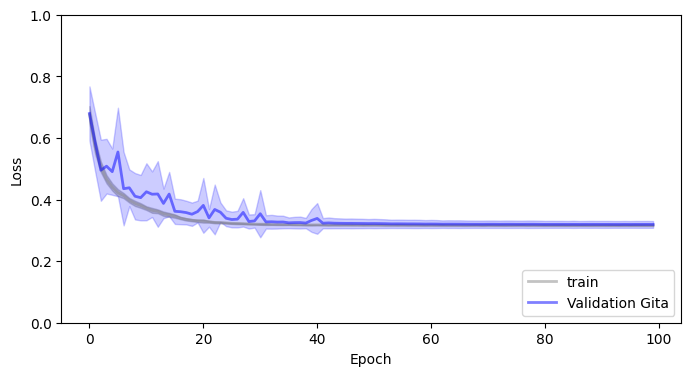

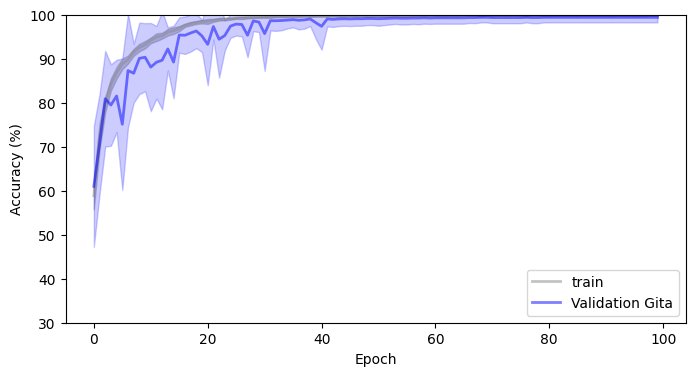

In [ ]:
results_loss_Epochs_mean=np.stack(results_loss_Epochs,0).mean(axis=0)
results_loss_Epochs_std=np.stack(results_loss_Epochs,0).std(axis=0)

results_val_loss_Gita_Epochs_mean=np.stack(results_val_loss_Gita_Epochs,0).mean(axis=0)
results_val_loss_Gita_Epochs_std=np.stack(results_val_loss_Gita_Epochs,0).std(axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(epoch+1),results_loss_Epochs_mean, alpha=0.5, color='#888888', label='train', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_loss_Epochs_mean - results_loss_Epochs_std, results_loss_Epochs_mean + results_loss_Epochs_std, color='#888888', alpha=0.4)

ax.plot(range(epoch+1),results_val_loss_Gita_Epochs_mean, alpha=0.5, color='blue', label='Validation Gita', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_loss_Gita_Epochs_mean - results_val_loss_Gita_Epochs_std, results_val_loss_Gita_Epochs_mean + results_val_loss_Gita_Epochs_std, color='blue', alpha=0.2)


ax.set_ylim([0,1])
ax.legend(loc='lower right')
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
plt.savefig("/content/drive/MyDrive/Memoria/speed_change/test5/duplicado/Loss_Train_Validation_pataka.pdf", dpi=150)

results_metric_Epochs_mean=np.stack(results_metric_Epochs,0).mean(axis=0)
results_metric_Epochs_std=np.stack(results_metric_Epochs,0).std(axis=0)

results_val_metric_Gita_Epochs_mean=np.stack(results_val_metric_Gita_Epochs,0).mean(axis=0)
results_val_metric_Gita_Epochs_std=np.stack(results_val_metric_Gita_Epochs,0).std(axis=0)


fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(epoch+1),results_metric_Epochs_mean, alpha=0.5, color='#888888', label='train', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_metric_Epochs_mean - results_metric_Epochs_std, results_metric_Epochs_mean + results_metric_Epochs_std, color='#888888', alpha=0.4)

ax.plot(range(epoch+1),results_val_metric_Gita_Epochs_mean, alpha=0.5, color='blue', label='Validation Gita', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_metric_Gita_Epochs_mean - results_val_metric_Gita_Epochs_std, results_val_metric_Gita_Epochs_mean + results_val_metric_Gita_Epochs_std, color='blue', alpha=0.2)

ax.set_ylim([30,100])
ax.legend(loc='lower right')

ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epoch")
plt.savefig("/content/drive/MyDrive/Memoria/speed_change/test5/duplicado/Accuracy_Train_Validation_pataka_prob_100.pdf", dpi=150)

In [ ]:
print(f'Gita: Accuracy by windows:, {np.mean(val_windows_metrics_Gita):.2f} ({np.std(val_windows_metrics_Gita):.2f})%,Accuracy by subject:{np.mean(val_subject_metrics_Gita):.2f} ({np.std(val_subject_metrics_Gita):.2f})')

Gita: Accuracy by windows:, 99.39 (1.14)%,Accuracy by subject:100.00 (0.00)


In [ ]:
def plot_ROC_k_fold(fpr_k_folds,tpr_k_folds,auc_k_folds,folds, color):
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    tprs=[]
    for k in range(folds):
        #display = sklearn.metrics.RocCurveDisplay(fpr=fpr_k_folds[k], tpr=tpr_k_folds[k], roc_auc=auc_k_folds[k],
        #                           estimator_name='ROC fold'+str(k))
        #display.plot()

        interp_tpr = np.interp(mean_fpr, fpr_k_folds[k], tpr_k_folds[k])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc =np.mean(auc_k_folds)
    std_auc = np.std(auc_k_folds)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=color,
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color=color,
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
       # title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.savefig("/content/drive/MyDrive/Memoria/speed_change/test5/duplicado/ROC_Subject_fpr_Gita.pdf", dpi=150)
    plt.show()


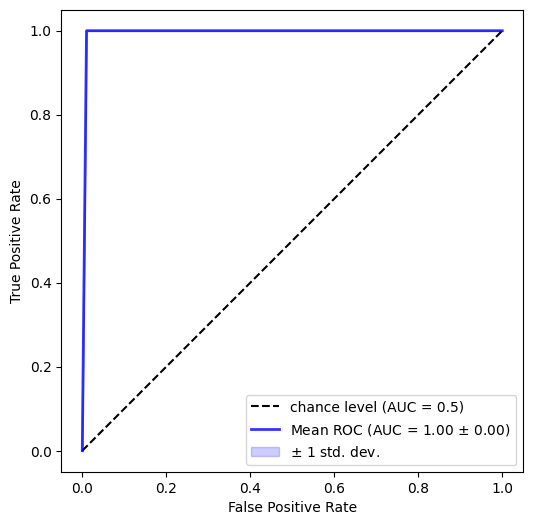

In [ ]:
plot_ROC_k_fold(Subject_fpr_Gita,Subject_tpr_Gita,Subject_AUC_Gita, 10, 'blue')
#df=pd.DataFrame({'Subject_fpr_Gita':np.transpose(Subject_fpr_Gita),'Subject_tpr_Gita':np.transpose(Subject_tpr_Gita),
#                 'Subject_AUC_Gita':np.transpose(Subject_AUC_Gita) })
#df.to_csv('CNN_Gita_fpr_tpr_AUC_pataka.csv')

## Métricas Cross-Validation (Neurovoz)

In [ ]:
print(f'NeuroV: Accuracy:  {np.mean(test_subject_metrics_NeuroV):.2f} ({np.std(test_subject_metrics_NeuroV):.2f})%')
print(f'Test NeuroV: Accuracy by windows:, {np.mean(test_windows_metrics_NeuroV):.2f} ({np.std(test_windows_metrics_NeuroV):.2f})%,Accuracy by subject:{np.mean(test_subject_metrics_NeuroV):.2f} ({np.std(test_subject_metrics_NeuroV):.2f})')

NeuroV: Accuracy:  49.53 (1.49)%
Test NeuroV: Accuracy by windows:, 44.48 (2.20)%,Accuracy by subject:49.53 (1.49)


## Divergencia y varianza

In [ ]:
def KLdivergence(x, y):
#  """Compute the Kullback-Leibler divergence between two multivariate samples.
#  Parameters
#  ----------
#  x : 2D array (n,d)
#    Samples from distribution P, which typically represents the true
#    distribution.
#  y : 2D array (m,d)
#    Samples from distribution Q, which typically represents the approximate
#    distribution.
#  Returns
#  -------
#  out : float
#    The estimated Kullback-Leibler divergence D(P||Q).
#  References
#  ----------
#  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
#continuous distributions IEEE International Symposium on Information
#Theory, 2008.
#  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [ ]:
KL_HC_1=[]
KL_PD_1=[]
KL_HC_2=[]
KL_PD_2=[]
for k in range(10): #output por train, val por train
    KL_HC_1.append(KLdivergence(flattern_train_CNN_Original[k].data.cpu()[np.where(Y_Original_fold[k]==0)], flattern_train_CNN_Augmented[k].data.cpu()[np.where(Y_Augmented_fold[k]==0)]))
    KL_HC_2.append(KLdivergence(flattern_train_CNN_Augmented[k].data.cpu()[np.where(Y_Augmented_fold[k]==0)], flattern_train_CNN_Original[k].data.cpu()[np.where(Y_Original_fold[k]==0)]))

    KL_PD_1.append(KLdivergence(flattern_train_CNN_Original[k].data.cpu()[np.where(Y_Original_fold[k]==1)], flattern_train_CNN_Augmented[k].data.cpu()[np.where(Y_Augmented_fold[k]==1)]))
    KL_PD_2.append(KLdivergence(flattern_train_CNN_Augmented[k].data.cpu()[np.where(Y_Augmented_fold[k]==1)], flattern_train_CNN_Original[k].data.cpu()[np.where(Y_Original_fold[k]==1)]))



print(f'KL para HC, {np.mean(KL_HC_1):.2f} ({np.std(KL_HC_1):.2f})')
print(f'KL para HC, {np.mean(KL_HC_2):.2f} ({np.std(KL_HC_2):.2f})')

print(f'KL para PD, {np.mean(KL_PD_1):.2f} ({np.std(KL_PD_1):.2f})')
print(f'KL para PD, {np.mean(KL_PD_2):.2f} ({np.std(KL_PD_2):.2f})')
print('')

print(f'KL para HC, {np.mean([KL_HC_1, KL_HC_2]):.2f} ({np.std([KL_HC_1, KL_HC_2]):.2f})')
print(f'KL para PD, {np.mean([KL_PD_1, KL_PD_2]):.2f} ({np.std([KL_PD_1, KL_PD_2]):.2f})')

KL para HC, -272.56 (9.86)
KL para HC, -244.30 (8.78)
KL para PD, -286.62 (4.78)
KL para PD, -256.69 (3.97)

KL para HC, -258.43 (16.94)
KL para PD, -271.66 (15.60)


Varianza

In [ ]:
Variance_HC, Variance_PD=[],[]
for k in range(10): #output o val por train
    Original_features_HC=flattern_train_CNN_Original[k].data.cpu()[np.where(Y_Original_fold[k]==0)]
    Augmented_features_HC=flattern_train_CNN_Augmented[k].data.cpu()[np.where(Y_Augmented_fold[k]==0)]
    Original_features_PD=flattern_train_CNN_Original[k].data.cpu()[np.where(Y_Original_fold[k]==1)]
    Augmented_features_PD=flattern_train_CNN_Augmented[k].data.cpu()[np.where(Y_Augmented_fold[k]==1)]

    features_HC=torch.concat([Original_features_HC, Augmented_features_HC])
    features_PD=torch.concat([Original_features_PD, Augmented_features_PD])
    Variance_HC.append(np.trace(np.cov(np.transpose(features_HC))))
    Variance_PD.append(np.trace(np.cov(np.transpose(features_PD))))

print(f'Cov para HC, {np.mean(Variance_HC):.2f} ({np.std(Variance_HC):.2f})')
print(f'Cov para PD, {np.mean(Variance_PD):.2f} ({np.std(Variance_PD):.2f})')

Cov para HC, 11.02 (2.25)
Cov para PD, 18.40 (1.71)


## T-SNE

In [ ]:
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    colores=[(0,0.6,1), (0,0,1), (1,0.5,0.5), (1,0,0)  ]

    for i in range(X.shape[0]):
        # plot colored number
        #plt.text(X[i, 0], X[i, 1], 'o',
        #         color=colores[y[i]],
        #         fontdict={ 'size': 14})
        plt.plot(X[i, 0], X[i, 1], 'o',
                 color=colores[y[i]],#plt.cm.brw(y[i]),
                  )

    plt.xticks([]), plt.yticks([])
    plt.legend(['Augmented_HC', 'Augmented_PD', 'Original_HC', 'Original_PD'] )
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color((0,0.6,1))
    leg.legendHandles[1].set_color((0,0,1))
    leg.legendHandles[2].set_color((1,0.5,0.5))
    leg.legendHandles[3].set_color((1,0,0))
    if title is not None:
        plt.title(title)

In [ ]:
t_SNE= TSNE(n_components=2,n_iter=500,n_iter_without_progress=150, n_jobs=2, random_state=0)

for k in range(10):
    CCN_train=np.concatenate([flattern_train_CNN_Augmented[k].data.cpu(), flattern_train_CNN_Original[k].data.cpu()])
    Y_train=np.concatenate([ Y_train_Augmented_fold[k].data.cpu(), Y_train_Original_fold[k].data.cpu()])
    Y_train_plot=np.concatenate([Y_train_Augmented_fold[k].data.cpu(), Y_train_Original_fold[k].data.cpu()+2])
    domain_train=np.concatenate([np.ones( Y_train_Augmented_fold[k].shape), np.zeros(Y_train_Original_fold[k].shape)])

    projections=t_SNE.fit_transform(CCN_train,Y_train)

    plot_embedding(projections,Y_train_plot,domain_train, 't-SNE embeedding')
    plt.savefig("/content/drive/MyDrive/Memoria/speed_change/test5/duplicado/T-SNE{}.pdf".format(k), dpi=150)

    plt.show()

# Train with: NeuroVoz

## Processing

In [ ]:
#selecting 400ms overlap in 50ms of audio signal example
def process_select_signals(data, SAMPLE_RATE, want_to_augment = True):
    time_leng=0.4 #Esto son 400 ms.
    sample_leng=int(time_leng*SAMPLE_RATE) #Sample_rate = 44100. sample_leng = 0.4*44100 = 17640
    overloap=2
    signals, y_label, subject_group, tono =[],[],[],[]
    data_size = len(data)
    total_segments=0
    processed_audios = 0

    if want_to_augment:
      augmentedSignals, augmentedY_label, augmentedSubject_group =[],[],[]
      augmented_data_counter = 0
      augment_offset = 1000



    #Processs data to train
    for data_ind, file_path in enumerate(data.Path): #Obtengo los paths a los datos de audio
        audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE) #Cargo la señal de audio.

        augmented_flag = False

        if want_to_augment:
          prob_aug = random.random()
          if prob_aug <= 1: #Se va a aplicar siempre en este caso
            #Aplico data augmentation
            speed_rate = random.uniform(0.5,1.6)
            augmented_audio = librosa.effects.time_stretch(audio,rate=speed_rate)

            data_size += 1 #Tengo un audio más que procesar, el aumentado
            augmented_flag = True
            augmented_data_counter += 1

          #else: No aplico data augmentantion

        for a in range(2): #Pasamos 2 veces, una con el original, otra con el aumentado
          if want_to_augment and augmented_flag and a == 1:
              audio = augmented_audio
              #print("Now with the augmented data")
          elif (want_to_augment == False or augmented_flag == False) and a == 1:
              break;

          audio_len=len(audio)
          audio=audio/np.max(abs(audio)) #normalizamos
          indx=[i for i,x in enumerate(np.sqrt(abs(audio))) if x>.30]

          segments=0 #Segmentos de señal
          if (indx[0]+sample_leng)<audio_len:
              for i in range(int((-indx[0]+indx[len(indx)-1])/(sample_leng/overloap))):
                  ind_start = i * int(sample_leng/overloap)+indx[0]
                  ind_end = ind_start + sample_leng
                  if ind_end <= indx[len(indx)-1]:
                      signal=np.zeros(sample_leng)
                      signal = audio[ind_start:int(ind_end)]

                      if want_to_augment and augmented_flag and a == 1:
                        #print("Adding segment to the augmented list")
                        augmentedSignals.append(signal) #Guardo segmentos de las señales aumentadas
                        augmentedY_label.append(data.iloc[data_ind]['Label']) #Guardo su clasificación
                        augmentedSubject_group.append(data.iloc[data_ind]['Speaker_ID'] + augment_offset) #Guardo su ID del sujeto

                      elif a == 0:
                        #print("Adding segment to the real list")
                        signals.append(signal) #Guardo segmentos de las señales originales
                        y_label.append(data.iloc[data_ind]['Label']) #Guardo su clasificación
                        subject_group.append(data.iloc[data_ind]['Speaker_ID']) #Guardo su ID del sujeto

                      segments=segments+1
              processed_audios += 1
              print(" Processed {}/{} files".format(processed_audios,data_size),end='')
              print(" Time audio: {} Segments {} ".format((audio_len-1)/sample_rate,segments))
          else:
              print(" Processed {}/{} files".format(processed_audios,data_size),end='')
              print(" Time audio: {} Segments {} ".format((audio_len-1)/sample_rate,0))
          total_segments += segments

    print(" Total segments: ", total_segments)

    signals = np.stack(signals,axis=0)
    y_label = np.stack(y_label,axis=0)
    subject_group = np.stack(subject_group,axis=0)

    if want_to_augment:
      augmentedSignals = np.stack(augmentedSignals,axis=0)
      augmentedY_label = np.stack(augmentedY_label,axis=0)
      augmentedSubject_group = np.stack(augmentedSubject_group,axis=0)
      print(" Total augmentations: ", augmented_data_counter)
      return signals, y_label, subject_group, augmentedSignals, augmentedY_label, augmentedSubject_group

    else:
      return signals, y_label, subject_group

In [ ]:
# Data test GITA (sin data augmentation)
signals_test_Gita, y_label_test_Gita, subject_group_test_Gita = process_select_signals(data_train_Gita, SAMPLE_RATE, want_to_augment = False)

print("-"*40)
# Data train NeuroVoz + Data Augmentation
signals_train_NeuroV, y_label_train_NeuroV, subject_group_train_NeuroV, aug_signals, aug_labels, aug_groups = process_select_signals(data_test_NeuroV, SAMPLE_RATE)

### Verificación de tamaños

GITA

In [ ]:
print('size data train', signals_test_Gita.shape)  # Debería dar size data train (1962, 17640).
print('size labels train', y_label_test_Gita.shape)
print('size group subject train', subject_group_test_Gita.shape)

NeuroVoz

In [ ]:
print('size data test', signals_train_NeuroV.shape)  # Debería dar size data test (4985, 17640).
print('size labels test', y_label_train_NeuroV.shape)
print('size group subject test', subject_group_train_NeuroV.shape)

In [ ]:
print('size augmented signals', aug_signals.shape)
print('size labels augmented', aug_labels.shape)
print('size group subject augmented', aug_groups.shape)

## Espectrogramas

In [ ]:
def compute_norm_spect(signals, sample_rate):
    n_fft = 2048 #Numero de puntos
    win_length = int(0.015*sample_rate)  # Tamaño de la ventana
    hop_length = int(0.010*sample_rate)  # Tamaño del Hop
    n_mels = 65                          # Número de ventanas de Mel

    mel_spectrogram = T.MelSpectrogram(  #T from torchaudio.transforms. Configuración del espectrograma de Mel
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        #onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )


    mel_spectrograms = []
    scaler = StandardScaler()
    print("Calculating mel spectrograms")
    for i in range(signals.shape[0]):
        mel_spect = librosa.power_to_db(mel_spectrogram(torch.from_numpy(signals[i,:])))
        mel_spect_norm=scaler.fit_transform(mel_spect)
        mel_spectrograms.append(mel_spect_norm)
        print("\r Processed {}/{} files".format(i,signals.shape[0]),end='')
    mel_spectrograms = np.stack(mel_spectrograms,axis=0)
    print(' ')
    return mel_spectrograms

In [ ]:
#Data train
mel_spectrograms_train_NeuroV=compute_norm_spect(signals_train_NeuroV, SAMPLE_RATE)
aug_mel_spectrograms = compute_norm_spect(aug_signals, SAMPLE_RATE)
print('Data size:',mel_spectrograms_train_NeuroV.shape)

print("-"*40)
#Data test
mel_spectrograms_test_Gita=compute_norm_spect(signals_test_Gita, SAMPLE_RATE)
print('Data size:',mel_spectrograms_test_Gita.shape)

Calculating mel spectrograms
 Processed 4984/4985 files 
Calculating mel spectrograms
 Processed 5464/5465 files 
Data size: (4985, 65, 41)
----------------------------------------
Calculating mel spectrograms
 Processed 1961/1962 files 
Data size: (1962, 65, 41)


## Entrenamiento

In [ ]:
class CNN(nn.Module):

        def __init__(self, kernel_size_1=8, kernel_size_2=9, depth_CL=64, neurons_MLP=64, drop_out=0.2):
            super().__init__()

            # 1. conv block
            self.conv2Dblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                       out_channels=depth_CL,
                       kernel_size=kernel_size_1,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(depth_CL),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=drop_out),
            )

            # 2. conv block
            self.conv2Dblock2 = nn.Sequential(
            nn.Conv2d(in_channels=depth_CL,
                       out_channels=depth_CL,
                       kernel_size=kernel_size_2,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(depth_CL),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=drop_out),

            )

            self.MLP = nn.Sequential(
                nn.Linear(depth_CL*math.ceil((math.ceil((65-kernel_size_1)/2+1)-kernel_size_2)/2+1)
                          *math.ceil((math.ceil((41-kernel_size_1)/2+1)-kernel_size_2)/2+1),neurons_MLP),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            )

            self.out_softmax = nn.Sequential(
                nn.Linear(neurons_MLP,2),
                nn.Softmax(dim=1)
            )


        def forward(self,x):
            x = self.conv2Dblock1(x)
            conv_embedding = self.conv2Dblock2(x)
            conv_embedding = torch.flatten(conv_embedding, start_dim=1)
            MPL_output = self.MLP(conv_embedding)
            output_softmax = self.out_softmax(MPL_output)
            return output_softmax, MPL_output

In [ ]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def soft_output_by_subject(output_test, Y_test, subject_group_test, ):

    Y_test_bySubject= []
    output_test_bySubjects=torch.empty((1,2),device=output_test.device.type)
    subject_in_group=np.unique(subject_group_test)
    output_test_subject=torch.zeros(subject_in_group.shape)
    Y_estimated_test_subject=torch.ones(subject_in_group.shape)
    for i, speaker in enumerate(subject_in_group):
        index_speaker = np.where(subject_group_test==speaker)
        output_test_subject[i]=torch.mean(torch.log(output_test[index_speaker][:,1]) -torch.log(output_test[index_speaker][:,0]),0)
        Y_test_bySubject.append(Y_test[index_speaker][0])


    Y_test_tensor_bySubject = torch.tensor(Y_test_bySubject,dtype=torch.long,device=device)
    Y_estimated_test_subject[output_test_subject<0]=0
    return output_test_subject , Y_test_tensor_bySubject,Y_estimated_test_subject

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=10)

Data_NeuroV_strat=sgkf.split(mel_spectrograms_train_NeuroV, y=y_label_train_NeuroV, groups=subject_group_train_NeuroV)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("cuda")
    #torch.cuda.set_device(1)

BATCH_SIZE = 64


#Data to test Gita
X_test_Gita =np.expand_dims(np.stack(mel_spectrograms_test_Gita, axis=0),1)
Y_test_Gita= y_label_test_Gita
X_test_tensor_Gita = torch.tensor(X_test_Gita,device=device).float()
Y_test_tensor_Gita = torch.tensor(Y_test_Gita,dtype=torch.long,device=device)


#Métricas del modelo
results_val_metric_subject_NeuroV  = []
Subject_Sen_spe_NeuroV, Subject_f1_score_NeuroV, Subject_MCC_NeuroV, Subject_AUC_NeuroV=[],[],[],[]
Subject_fpr_NeuroV, Subject_tpr_NeuroV=[],[]
results_loss_Epochs, results_metric_Epochs= [], []
results_val_metric_NeuroV_Epochs, results_val_loss_NeuroV_Epochs=[],[]

#Métricas de validación con el mismo dataset
val_windows_metrics_NeuroV, val_subject_metrics_NeuroV=[],[]

#Para test con Gita
test_windows_metrics_Gita, test_subject_metrics_Gita=[],[]

#Para T-SNE:
flattern_train_CNN_Original, Y_train_Original_fold =[],[]
flattern_train_CNN_Augmented, Y_train_Augmented_fold =[],[]

for k in range(10):
    results_loss, results_metric, results_val_metric_NeuroV, results_val_loss_NeuroV,  = [], [], [], []


    print('')
    print(f"\k-fold {k + 1} \n***********************")

    train_index_NeuroV, val_index_NeuroV =next(iter(Data_NeuroV_strat))

    print(np.unique(subject_group_train_NeuroV[val_index_NeuroV])) #Imprimo los índices que serán usados en validation


    #Variables para T-SNE
    X_Original = np.expand_dims(np.stack(mel_spectrograms_train_NeuroV[train_index_NeuroV,:,:], axis=0),1)
    X_tensor_Original = torch.tensor(X_Original,device=device).float()
    Y_tensor_Original = torch.tensor(y_label_train_NeuroV[train_index_NeuroV], dtype=torch.long,device=device)

    X_Augmented = np.expand_dims(np.stack(aug_mel_spectrograms, axis=0),1)
    X_tensor_Augmented = torch.tensor(X_Augmented,device=device).float()
    Y_tensor_Augmented = torch.tensor(aug_labels, dtype=torch.long,device=device)

    #Data to train. Augmented variables: aug_signals, aug_labels, aug_groups, aug_mel_spectrograms

    X_train = np.expand_dims(np.stack(np.concatenate([mel_spectrograms_train_NeuroV[train_index_NeuroV,:,:], aug_mel_spectrograms], axis=0), axis=0),1) #Acá poner + augmentedSpec
    Y_train = np.concatenate([y_label_train_NeuroV[train_index_NeuroV], aug_labels],axis=0) #Aca igua ponerle las de augmented

    X_tensor = torch.tensor(X_train,device=device).float()
    Y_tensor = torch.tensor(Y_train, dtype=torch.long,device=device)

    subject_group_train=np.concatenate([subject_group_train_NeuroV[train_index_NeuroV], aug_groups],axis=0)#Acá igual concatenar las de augmented


    #Data to val NeuroV
    X_val_NeuroV =np.expand_dims(np.stack(mel_spectrograms_train_NeuroV[val_index_NeuroV,:,:], axis=0),1)
    Y_val_NeuroV= y_label_train_NeuroV[val_index_NeuroV]
    subject_group_val_NeuroV=subject_group_train_NeuroV[val_index_NeuroV]
    X_val_tensor_NeuroV = torch.tensor(X_val_NeuroV,device=device).float()
    Y_val_tensor_NeuroV = torch.tensor(Y_val_NeuroV,dtype=torch.long,device=device)


    DATASET_SIZE=X_train.shape[0]
    iters = int(DATASET_SIZE / BATCH_SIZE)

    model = CNN().to(device)
    model.apply(reset_weights)


    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    lambda1 = lambda epoch: 0.95 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


    dataset=TensorDataset(X_tensor,Y_tensor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(100): #100 épocas
        epoch_acc = 0
        epoch_loss = 0
        for id_batch, (x_batch, y_batch) in enumerate(dataloader):
            actual_batch_size=x_batch.shape[0]

            # zero the parameter gradients
            model.train()
            optimizer.zero_grad()

            # forward
            outputs = model(x_batch)[0]

            # calculate accuracy
            prediction = torch.max(outputs, 1)[1]
            metric = sklearn.metrics.accuracy_score(y_batch.data.cpu(), prediction.data.cpu())*100


            # calculate loss + backward + optimize
            loss = loss_func(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_acc += metric*actual_batch_size/DATASET_SIZE
            epoch_loss += loss.item()*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch +1}: iteration {id_batch +1}/{iters} Acc_class: {epoch_acc:.2f}",end='')


        scheduler.step()

        with torch.no_grad():
            model.eval()
            output_val_NeuroV = model(X_val_tensor_NeuroV)[0]
            prediction_val_NeuroV = torch.max(output_val_NeuroV, 1)[1]
            val_metric_NeuroV = sklearn.metrics.accuracy_score(Y_val_tensor_NeuroV.data.cpu(), prediction_val_NeuroV.data.cpu())*100
            val_loss_NeuroV = loss_func(output_val_NeuroV, Y_val_tensor_NeuroV.data)

            output_val_bySubjects_NeuroV, Y_val_tensor_bySubject_NeuroV, prediction_val_bySubject_NeuroV =soft_output_by_subject(output_val_NeuroV, Y_val_NeuroV, subject_group_val_NeuroV)
            val_metric_subject_NeuroV = sklearn.metrics.accuracy_score(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())*100

        # append history
        results_loss.append(epoch_loss)
        results_metric.append(epoch_acc)
        results_val_metric_NeuroV.append(val_metric_NeuroV)
        results_val_metric_subject_NeuroV.append(val_metric_subject_NeuroV)
        results_val_loss_NeuroV.append(val_loss_NeuroV.item())


    print('')
    print(f"\r validation NeuroV: {val_metric_NeuroV:.2f} % by Subject: {val_metric_subject_NeuroV:.2f}%  ")

    #compute metrics
    Sen_spe_subject_NeuroV=sensitivity_specificity_support(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu(), average='binary')*100
    val_f1_score_NeuroV = sklearn.metrics.f1_score(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())*100
    val_MCC_NeuroV = sklearn.metrics.matthews_corrcoef(Y_val_tensor_bySubject_NeuroV.data.cpu(), prediction_val_bySubject_NeuroV.data.cpu())
    val_fpr_NeuroV, val_tpr_NeuroV, _ = sklearn.metrics.roc_curve(Y_val_tensor_bySubject_NeuroV.data.cpu(), output_val_bySubjects_NeuroV.data.cpu())
    val_AUC_NeuroV = sklearn.metrics.auc(val_fpr_NeuroV, val_tpr_NeuroV)

    #Métricas para T-SNE
    with torch.no_grad():
        model.eval()
        output_train_Original, train_CNN_Original = model(X_tensor_Original)
        output_train_Augmented, train_CNN_Augmented = model(X_tensor_Augmented)

    with torch.no_grad():
        model.eval()
        output_test_Gita, output_CNN_Gita = model(X_test_tensor_Gita)
        prediction_test_Gita = torch.max(output_test_Gita, 1)[1]

    test_metric_Gita = sklearn.metrics.accuracy_score(Y_test_tensor_Gita.data.cpu(), prediction_test_Gita.data.cpu())*100

    output_test_bySubjects_Gita, Y_test_tensor_bySubject_Gita, prediction_test_bySubject_Gita =soft_output_by_subject( output_test_Gita, Y_test_Gita, subject_group_test_Gita)
    test_metric_subject_Gita = sklearn.metrics.accuracy_score(Y_test_tensor_bySubject_Gita.data.cpu(), prediction_test_bySubject_Gita.data.cpu())*100

    results_loss_Epochs.append(results_loss)
    results_metric_Epochs.append(results_metric)
    results_val_metric_NeuroV_Epochs.append(results_val_metric_NeuroV)
    results_val_loss_NeuroV_Epochs.append(results_val_loss_NeuroV)

    val_windows_metrics_NeuroV.append(val_metric_NeuroV)
    val_subject_metrics_NeuroV.append(val_metric_subject_NeuroV)
    Subject_Sen_spe_NeuroV.append([Sen_spe_subject_NeuroV[0]*100, Sen_spe_subject_NeuroV[1]*100])
    Subject_f1_score_NeuroV.append(val_f1_score_NeuroV)
    Subject_MCC_NeuroV.append(val_MCC_NeuroV)
    Subject_AUC_NeuroV.append(val_AUC_NeuroV)
    Subject_fpr_NeuroV.append(val_fpr_NeuroV)
    Subject_tpr_NeuroV.append(val_tpr_NeuroV)


    #Variables para T-SNE
    flattern_train_CNN_Original.append(train_CNN_Original)
    Y_train_Original_fold.append(Y_tensor_Original)
    flattern_train_CNN_Augmented.append(train_CNN_Augmented)
    Y_train_Augmented_fold.append(Y_tensor_Augmented)

    test_windows_metrics_Gita.append(test_metric_Gita)
    test_subject_metrics_Gita.append(test_metric_subject_Gita)

    torch.save(model.state_dict(), '/content/drive/MyDrive/Memoria/speed_change/test5/trainNeurovoz/CNN_NeuroV_pataka_fold_'+str(k)+'.pt')

# MÉTRICAS

## Métricas con Neurovoz

In [ ]:
#Métricas
print(f'NeuroV: Accuracy:    {np.mean(val_subject_metrics_NeuroV):.2f} ({np.std(val_subject_metrics_NeuroV):.2f})%')
print(f"\r      Sensitivity: {np.mean(np.stack(Subject_Sen_spe_NeuroV,0),0)[0]:.2f} ({np.std(np.stack(Subject_Sen_spe_NeuroV,0),0)[0]:.2f})% ")
print(f"\r      Specifity:   {np.mean(np.stack(Subject_Sen_spe_NeuroV,0),0)[1]:.2f} ({np.std(np.stack(Subject_Sen_spe_NeuroV,0),0)[1]:.2f})% ")
print(f'\r      f1_score:    {np.mean(Subject_f1_score_NeuroV):.2f} ({np.std(Subject_f1_score_NeuroV):.2f})%')
print(f'\r      MCC:         {np.mean(Subject_MCC_NeuroV):.2f} ({np.std(Subject_MCC_NeuroV):.2f})')
print(f'\r      AUC:         {np.mean(Subject_AUC_NeuroV):.2f} ({np.std(Subject_AUC_NeuroV):.2f})')


NeuroV: Accuracy:    98.89 (3.33)%
      Sensitivity: 100.00 (0.00)% 
      Specifity:   97.50 (7.50)% 
      f1_score:    99.09 (2.73)%
      MCC:         0.98 (0.06)
      AUC:         0.98 (0.05)


In [ ]:
print(f'NeuroV: Accuracy by windows:, {np.mean(val_windows_metrics_NeuroV):.2f} ({np.std(val_windows_metrics_NeuroV):.2f})%,Accuracy by subject:{np.mean(val_subject_metrics_NeuroV):.2f} ({np.std(val_subject_metrics_NeuroV):.2f})')

NeuroV: Accuracy by windows:, 96.40 (2.78)%,Accuracy by subject:98.89 (3.33)


## Cross-Validation con Gita

In [ ]:
print(f'Gita: Accuracy:  {np.mean(test_subject_metrics_Gita):.2f} ({np.std(test_subject_metrics_Gita):.2f})%')
print(f'Test Gita: Accuracy by windows:, {np.mean(test_windows_metrics_Gita):.2f} ({np.std(test_windows_metrics_Gita):.2f})%,Accuracy by subject:{np.mean(test_subject_metrics_Gita):.2f} ({np.std(test_subject_metrics_Gita):.2f})')

Gita: Accuracy:  47.50 (2.80)%
Test Gita: Accuracy by windows:, 47.66 (1.66)%,Accuracy by subject:47.50 (2.80)


## Curvas (Accuracy, Loss, ROC y T-SNE)

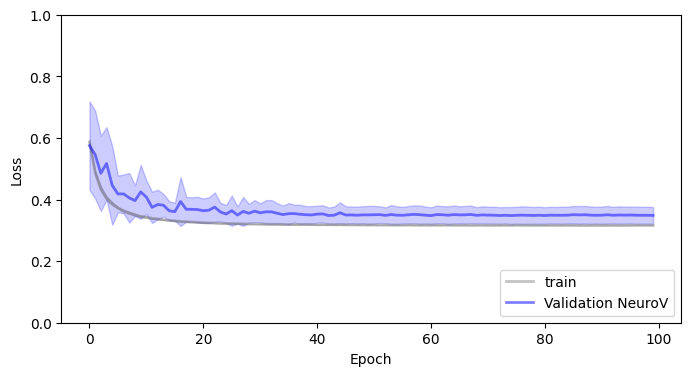

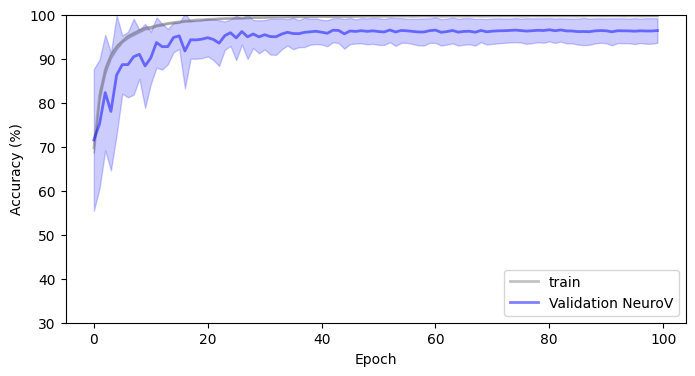

In [ ]:
results_loss_Epochs_mean=np.stack(results_loss_Epochs,0).mean(axis=0)
results_loss_Epochs_std=np.stack(results_loss_Epochs,0).std(axis=0)

results_val_loss_NeuroV_Epochs_mean=np.stack(results_val_loss_NeuroV_Epochs,0).mean(axis=0)
results_val_loss_NeuroV_Epochs_mean=np.stack(results_val_loss_NeuroV_Epochs,0).mean(axis=0)
results_val_loss_NeuroV_Epochs_std=np.stack(results_val_loss_NeuroV_Epochs,0).std(axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(epoch+1),results_loss_Epochs_mean, alpha=0.5, color='#888888', label='train', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_loss_Epochs_mean - results_loss_Epochs_std, results_loss_Epochs_mean + results_loss_Epochs_std, color='#888888', alpha=0.4)

ax.plot(range(epoch+1),results_val_loss_NeuroV_Epochs_mean, alpha=0.5, color='blue', label='Validation NeuroV', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_loss_NeuroV_Epochs_mean - results_val_loss_NeuroV_Epochs_std, results_val_loss_NeuroV_Epochs_mean + results_val_loss_NeuroV_Epochs_std, color='blue', alpha=0.2)


ax.set_ylim([0,1])
ax.legend(loc='lower right')
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
plt.savefig("/content/drive/MyDrive/Memoria/speed_change/test5/trainNeurovoz/Loss_Train_Validation_pataka.pdf", dpi=150)

results_metric_Epochs_mean=np.stack(results_metric_Epochs,0).mean(axis=0)
results_metric_Epochs_std=np.stack(results_metric_Epochs,0).std(axis=0)

results_val_metric_NeuroV_Epochs_mean=np.stack(results_val_metric_NeuroV_Epochs,0).mean(axis=0)
results_val_metric_NeuroV_Epochs_std=np.stack(results_val_metric_NeuroV_Epochs,0).std(axis=0)


fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(epoch+1),results_metric_Epochs_mean, alpha=0.5, color='#888888', label='train', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_metric_Epochs_mean - results_metric_Epochs_std, results_metric_Epochs_mean + results_metric_Epochs_std, color='#888888', alpha=0.4)

ax.plot(range(epoch+1),results_val_metric_NeuroV_Epochs_mean, alpha=0.5, color='blue', label='Validation NeuroV', linewidth = 2.0)
ax.fill_between(range(epoch+1), results_val_metric_NeuroV_Epochs_mean - results_val_metric_NeuroV_Epochs_std, results_val_metric_NeuroV_Epochs_mean + results_val_metric_NeuroV_Epochs_std, color='blue', alpha=0.2)

ax.set_ylim([30,100])
ax.legend(loc='lower right')

ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epoch")
plt.savefig("/content/drive/MyDrive/Memoria/speed_change/test5/trainNeurovoz/Accuracy_Train_Validation_pataka_prob_100.pdf", dpi=150)

In [ ]:
def plot_ROC_k_fold(fpr_k_folds,tpr_k_folds,auc_k_folds,folds, color):
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    tprs=[]
    for k in range(folds):
        #display = sklearn.metrics.RocCurveDisplay(fpr=fpr_k_folds[k], tpr=tpr_k_folds[k], roc_auc=auc_k_folds[k],
        #                           estimator_name='ROC fold'+str(k))
        #display.plot()

        interp_tpr = np.interp(mean_fpr, fpr_k_folds[k], tpr_k_folds[k])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc =np.mean(auc_k_folds)
    std_auc = np.std(auc_k_folds)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=color,
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color=color,
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
       # title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.savefig("/content/drive/MyDrive/Memoria/speed_change/test5/trainNeurovoz/ROC_Subject_fpr_NeuroV.pdf", dpi=150)
    plt.show()


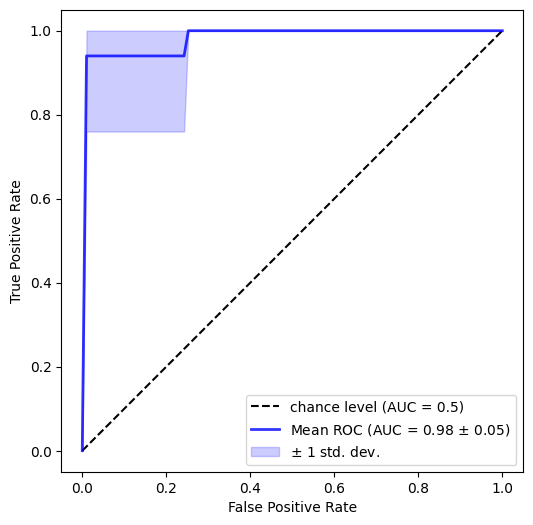

In [ ]:
plot_ROC_k_fold(Subject_fpr_NeuroV,Subject_tpr_NeuroV,Subject_AUC_NeuroV, 10, 'blue')

### t-SNE

In [ ]:
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    colores=[(0,0.6,1), (0,0,1), (1,0.5,0.5), (1,0,0)  ]

    for i in range(X.shape[0]):
        # plot colored number
        #plt.text(X[i, 0], X[i, 1], 'o',
        #         color=colores[y[i]],
        #         fontdict={ 'size': 14})
        plt.plot(X[i, 0], X[i, 1], 'o',
                 color=colores[y[i]],#plt.cm.brw(y[i]),
                  )

    plt.xticks([]), plt.yticks([])
    plt.legend(['Augmented_HC', 'Augmented_PD', 'Original_HC', 'Original_PD'] )
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color((0,0.6,1))
    leg.legendHandles[1].set_color((0,0,1))
    leg.legendHandles[2].set_color((1,0.5,0.5))
    leg.legendHandles[3].set_color((1,0,0))
    if title is not None:
        plt.title(title)

In [ ]:
t_SNE= TSNE(n_components=2,n_iter=500,n_iter_without_progress=150, n_jobs=2, random_state=0)

for k in range(10):
    CCN_train=np.concatenate([flattern_train_CNN_Augmented[k].data.cpu(), flattern_train_CNN_Original[k].data.cpu()])
    Y_train=np.concatenate([ Y_train_Augmented_fold[k].data.cpu(), Y_train_Original_fold[k].data.cpu()])
    Y_train_plot=np.concatenate([Y_train_Augmented_fold[k].data.cpu(), Y_train_Original_fold[k].data.cpu()+2])
    domain_train=np.concatenate([np.ones( Y_train_Augmented_fold[k].shape), np.zeros(Y_train_Original_fold[k].shape)])

    projections=t_SNE.fit_transform(CCN_train,Y_train)

    plot_embedding(projections,Y_train_plot,domain_train, 't-SNE embeedding')
    plt.savefig("/content/drive/MyDrive/Memoria/speed_change/test5/trainNeurovoz/T-SNE{}.pdf".format(k), dpi=150)

    plt.show()
